In [1]:
import torch
import copy
from tqdm import tqdm
import numpy as np
from utils.data_utils import create_synthetic_train_data, f
from models.last_layer_models import LLI, train_last_layer_det
from torch.utils.data import DataLoader, TensorDataset
from models.gibbs_sampler import gibbs_sampler, get_pred_post_dist
import pickle

import matplotlib.pyplot as plt

# Influence on the prior variance of the backbone 

We want to find out what influence the training settings for the backbone have on post-hoc last-layer inference. We know that many regularization penalties can be interpreted as a prior on the weights. For example the weight decay (L2 regularization) is a normal prior on the weights. And the factor which scales the weight decay is the inverse variance of this normal prior.

To examine the influence of this variance, we train a backbone $\psi_{\theta}$ with three different weight decay factors:
1. wd = 0
2. wd = 0.05
3. wd = 2
and fit LLI with each of these backbones.

For the data, we again use a noisy sine function:
\begin{align}
    y = \sin(x) + \varepsilon, \, \text{with} \quad \varepsilon \sim \mathcal{N}(0, \sigma_0^2)
\end{align}

In [2]:
sigma_eps = 0.3
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = sigma_eps)
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

We also use the same architecture as before, a dense, feedforward ReLU network.

In [3]:
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100
lli_net = LLI(model_dims)
sigma_0 = 0.3

In [4]:
wds = [0, 0.01, 0.05]
lli_nets = {}
Psi_trains = {}
Psi_tests =  {}
for wd in wds:
    lli_net = LLI(model_dims)
    lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs, weight_decay = wd)
    
    with torch.no_grad():
        Psi_train = lli_net.get_ll_embedd(xs_train)
        Xs_test = torch.arange(-10,10, 0.01).unsqueeze(-1).float()
        Psi_test = lli_net.get_ll_embedd(Xs_test)
    
    lli_nets[f'wd_{wd}'] = copy.deepcopy(lli_net)
    Psi_trains[f'wd_{wd}'] = Psi_train.detach()
    Psi_tests[f'wd_{wd}'] = Psi_test.detach()

100%|██████████| 100/100 [00:00<00:00, 170.62it/s]


In [10]:
a_tau = 2
b_tau = 2
a_sigma = 2
b_sigma = 2
num_iter =2000
warm_up = 1500

preds = {}
for lli_net, wd in zip(lli_nets, wds):
    # fit gibbs
    Psi_train = Psi_trains[f'wd_{wd}']
    Psi_test = Psi_tests[f'wd_{wd}']
    w_sample, tau_sq_sample, sigma_sq_sample = gibbs_sampler(Psi_train, ys_train, 
                    a_tau, b_tau, a_sigma, b_sigma, num_iter, warm_up)
    
    # predict on test
    ys_grid = torch.arange(-5,5, .01)

    preds[f'mean_{wd}'] = []
    preds[f'std_{wd}'] = []
    preds[f'p5_{wd}'] = []
    preds[f'p25_{wd}'] = []
    preds[f'p40_{wd}'] = []
    preds[f'p60_{wd}'] = []
    preds[f'p75_{wd}'] = []
    preds[f'p95_{wd}'] = []
    for i in tqdm(range(Psi_test.shape[0])):
        pdf_gibbs_ridge , y_mean, y_var = get_pred_post_dist(Psi_test[i], w_sample, sigma_sq_sample, ys_grid)
        pdf_gibbs_ridge = pdf_gibbs_ridge / np.trapezoid(pdf_gibbs_ridge, ys_grid)
        preds[f'mean_{wd}'].append(y_mean)
        cdf = np.cumsum(pdf_gibbs_ridge) * (ys_grid[1].detach().numpy() - ys_grid[0].detach().numpy())

        # Find the 5%, 50%, 95% quantiles
        p5  = ys_grid[np.searchsorted(cdf, 0.05)]
        p25 = ys_grid[np.searchsorted(cdf, 0.25)]
        p40 = ys_grid[np.searchsorted(cdf, 0.4)]
        p60 = ys_grid[np.searchsorted(cdf, 0.6)]
        p75 = ys_grid[np.searchsorted(cdf, 0.75)]
        p95 = ys_grid[np.searchsorted(cdf, 0.95)]
        preds[f'std_{wd}'].append(np.sqrt(y_var))
        preds[f'p5_{wd}'].append(p5)
        preds[f'p25_{wd}'].append(p25)
        preds[f'p40_{wd}'].append(p40)
        preds[f'p60_{wd}'].append(p60)
        preds[f'p75_{wd}'].append(p75)
        preds[f'p95_{wd}'].append(p95)


100%|██████████| 2000/2000 [00:24<00:00, 82.21it/s]


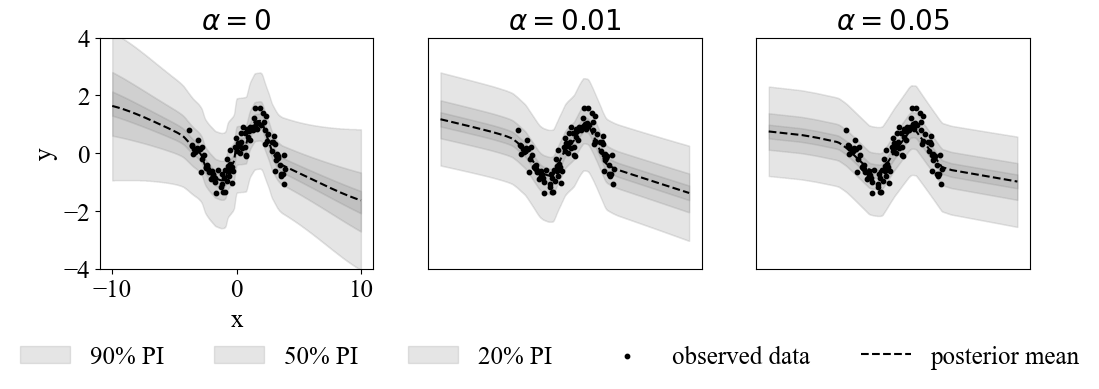

In [21]:
TEXT_SIZE = 18
xs_test_np = Xs_test.detach().numpy().squeeze()
ys_no_noise = np.array([f(x = x, noise = False, sigma_eps = sigma_eps) for x in xs])

plt.rcParams.update({'font.size': 18, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})
fig, axs = plt.subplots(1,3,figsize=(12, 3))

for i, wd in zip(range(3), wds):
    pred_mus =np.array(preds[f'mean_{wd}'])
    pred_sigmas = np.array(preds[f'std_{wd}'])
    
    # 80% PI
    pred_p5 = np.array(preds[f'p5_{wd}'])
    pred_p95 = np.array(preds[f'p95_{wd}'])
    # 50% PI
    pred_p25 = np.array(preds[f'p25_{wd}'])
    pred_p75 = np.array(preds[f'p75_{wd}'])
    # 20% PI
    pred_p40 = np.array(preds[f'p40_{wd}'])
    pred_p60 = np.array(preds[f'p60_{wd}'])

    if i == 0:
        
        #axs[i].fill_between(xs_test_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', label = r'$\pm$ 2 posterior SD', alpha = 0.2)
        axs[i].fill_between(xs_test_np, pred_p5,  pred_p95, color = 'grey', label = r'90% PI', alpha = 0.2)
        axs[i].fill_between(xs_test_np, pred_p25,  pred_p75, color = 'grey', label = r'50% PI', alpha = 0.2)
        axs[i].fill_between(xs_test_np, pred_p40,  pred_p60, color = 'grey', label = r'20% PI', alpha = 0.2)
        axs[i].set_xlabel('x', size = TEXT_SIZE)
        axs[i].set_xlabel('x', size = TEXT_SIZE)
        axs[i].set_ylabel('y', size = TEXT_SIZE)
        axs[i].scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
        axs[i].plot(xs_test_np, pred_mus, c = 'black', linestyle = 'dashed', label = 'posterior mean')
    else: 
        #axs[i].fill_between(xs_test_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', alpha = 0.2)
        axs[i].fill_between(xs_test_np, pred_p5, pred_p95, color = 'grey', alpha = 0.2)
        axs[i].fill_between(xs_test_np, pred_p25,  pred_p75, color = 'grey', alpha = 0.2)
        axs[i].fill_between(xs_test_np, pred_p40,  pred_p60, color = 'grey',  alpha = 0.2)
        axs[i].plot(xs_test_np, pred_mus, c = 'black', linestyle = 'dashed')
        axs[i].scatter(xs_train, ys_train, c = 'black', alpha = 1, s = 10)
        axs[i].set_yticks([], [])
        axs[i].set_xticks([], [])
    
    axs[i].set_title(fr'$\alpha = {wd}$', size = 20)
    axs[i].set_ylim(-4, 4)

fig.legend(ncols = 6, loc='lower center', 
           fontsize = TEXT_SIZE, bbox_to_anchor=(0.5, -0.3), frameon=False)
fig.savefig('figures/weight_decay.pdf', bbox_inches='tight')

In [22]:
with open("results/weight_decay_preds.pkl", "wb") as f:
    pickle.dump(preds, f)